# (IF702 - Redes Neurais) Análise de Risco de Crédito

## Divisão e balanceamento

In [1]:
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline

import scikitplot as skplt

import talos as ta

from imblearn.over_sampling import RandomOverSampler

from keras.activations import sigmoid
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.losses import mean_squared_error
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier

from numpy import concatenate, vstack, argmin

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle

from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
# Construir DataFrame a partir da base de dados.
data_set = pd.read_csv('data/TRN', sep='\t', index_col=0)

In [3]:
# Exibe as 5 primeiras linhas da base de dados.
data_set.head()

,UF_1,UF_2,UF_3,UF_4,UF_5,UF_6,UF_7,IDADE,SEXO_1,NIVEL_RELACIONAMENTO_CREDITO01,...,CEP4_7,CEP4_8,CEP4_9,CEP4_10,CEP4_11,CEP4_12,CEP4_13,CEP4_14,IND_BOM_1_1,IND_BOM_1_2
INDEX,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,0,0,0,0.135098,1,0.222222,...,0,0,1,1,0,1,1,1,0,1
1,1,0,1,0,0,1,0,0.273504,1,0.111111,...,0,1,0,1,1,0,0,0,1,0
2,1,0,1,0,0,1,0,0.281910,0,1.000000,...,1,1,0,0,0,0,1,0,1,0
3,1,1,1,0,0,0,0,0.225741,0,0.111111,...,1,1,0,1,1,0,1,0,1,0
4,1,1,0,0,0,1,0,0.480403,0,0.111111,...,1,1,1,0,0,1,0,1,1,0


In [4]:
# Separa as classes em DataFrames distintos.
class_1_df = data_set.loc[data_set['IND_BOM_1_2'] == 0] # Bom pagador.
class_2_df = data_set.loc[data_set['IND_BOM_1_2'] == 1] # Mau pagador.

In [5]:
# Separa "features" dos "targets" para cada classe, transformando-os em numpy arrays.
class_1_X = class_1_df.iloc[:, :-2].values
class_1_y = class_1_df.iloc[:, -1].values

class_2_X = class_2_df.iloc[:, :-2].values
class_2_y = class_2_df.iloc[:, -1].values

In [6]:
# Treino: 50%, Validação: 25%, Teste: 25% (para ambas as classes).
class_1_X_train, class_1_X_test, class_1_y_train, class_1_y_test = train_test_split(
    class_1_X, class_1_y, test_size=0.25, random_state=42, stratify=class_1_y)

class_1_X_train, class_1_X_val, class_1_y_train, class_1_y_val = train_test_split(
    class_1_X_train, class_1_y_train, test_size=(1./3), random_state=42, stratify=class_1_y_train)

class_2_X_train, class_2_X_test, class_2_y_train, class_2_y_test = train_test_split(
    class_2_X, class_2_y, test_size=0.25, random_state=42, stratify=class_2_y)

class_2_X_train, class_2_X_val, class_2_y_train, class_2_y_val = train_test_split(
    class_2_X_train, class_2_y_train, test_size=(1./3), random_state=42, stratify=class_2_y_train)

In [7]:
# Concatena os arrays de treinamento das classes (features e targets).
X_train = vstack((class_1_X_train, class_2_X_train))
y_train = concatenate([class_1_y_train, class_2_y_train])

# Concatena os arrays de validação das classes (features e targets).
X_val = vstack((class_1_X_val, class_2_X_val))
y_val = concatenate([class_1_y_val, class_2_y_val])

# Concatena os arrays de teste das classes (features e targets).
X_test = vstack((class_1_X_test, class_2_X_test))
y_test = concatenate([class_1_y_test, class_2_y_test])

In [8]:
# Over-sampling os conjuntos de treinamento e validação da classe 2 (minoritária).
ros = RandomOverSampler(random_state=0)

X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
X_val_resampled, y_val_resampled = ros.fit_resample(X_val, y_val)

## Variação dos hiperparâmetros (MLP e SVM)

In [9]:
def credit_risk_analisys_model(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(Dense(params['first_neuron'], activation='tanh', input_dim=x_train.shape[1]))
    
    model.add(Dense(1, activation=params['last_activation']))
              
    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    validation_data=[x_val, y_val],
                    verbose=2,
                    callbacks=early_stopper(params['epochs'], mode='strict'))

    return out, model

In [10]:
p = {'lr': [0.01, 0.1, 0.5, 1.0, 1.5, 3.0],
     'first_neuron':[2, 32, 128, 256],
     'batch_size': [64],
     'epochs': [100000],
     'optimizer': [SGD],
     'loss': [mean_squared_error],
     'last_activation': [sigmoid]}

In [ ]:
h = ta.Scan(x=X_train, y=y_train, params=p,
            x_val=X_val, y_val=y_val,
            dataset_name='credit_risk_analisys',
            experiment_no='1',
            model=credit_risk_analisys_model)

In [9]:
# use Scan object as input
# r = ta.Reporting(h)

# use filename as input
r = ta.Reporting('credit_risk_analisys_1.csv')

In [10]:
# access the dataframe with the results
r.data.head(-3)

,round_epochs,val_loss,val_acc,loss,acc,lr,first_neuron,batch_size,epochs,optimizer,loss.1,last_activation
0,14,0.206014,0.676043,0.204375,0.678077,3.00,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
1,22,0.207046,0.674728,0.206099,0.675589,1.00,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
2,105,0.206730,0.674553,0.206092,0.675774,0.10,128,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
3,35,0.207065,0.673484,0.206496,0.674330,0.50,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
4,20,0.206493,0.676146,0.205075,0.677660,1.50,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
5,7,0.208364,0.675478,0.206102,0.676119,3.00,128,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
6,8,0.206776,0.674481,0.206272,0.674762,1.50,256,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
7,15,0.206729,0.674471,0.206226,0.675076,1.50,2,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
8,7,0.206935,0.674697,0.206085,0.675261,3.00,256,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>
9,47,0.205942,0.676937,0.205138,0.677357,0.50,32,64,100000,<class 'keras.optimizers.SGD'>,<function mean_squared_error at 0x000001DB0CBB...,<function sigmoid at 0x000001DB0CC05048>


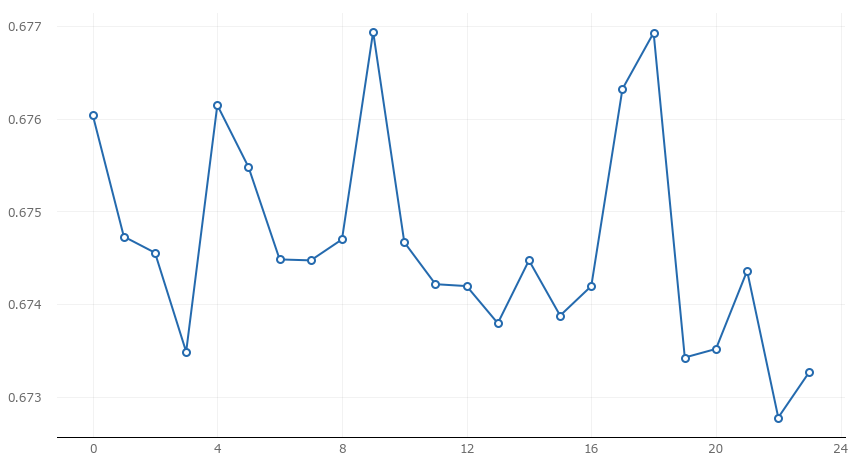

In [11]:
# line plot
r.plot_line()

## Definição e treino da rede

In [16]:
# Número de features do nosso data set.
input_dim = X_train.shape[1]

# Aqui criamos o esboço da rede.
classifier = Sequential()

# Agora adicionamos a primeira camada escondida contendo 16 neurônios e função de ativação
# tangente hiperbólica. Por ser a primeira camada adicionada à rede, precisamos especificar
# a dimensão de entrada (número de features do data set).
classifier.add(Dense(32, activation='tanh', input_dim=input_dim))

# Em seguida adicionamos a camada de saída. Como nosso problema é binário só precisamos de
# 1 neurônio com função de ativação sigmoidal. A partir da segunda camada adicionada keras já
# consegue inferir o número de neurônios de entrada (16) e nós não precisamos mais especificar.
classifier.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01)
# Por fim compilamos o modelo especificando um otimizador, a função de custo, e opcionalmente
# métricas para serem observadas durante treinamento.
classifier.compile(optimizer=sgd, loss='mean_squared_error')

In [17]:
# Para treinar a rede passamos o conjunto de treinamento e especificamos o tamanho do mini-batch,
# o número máximo de épocas, e opcionalmente callbacks. No seguinte exemplo utilizamos early
# stopping para interromper o treinamento caso a performance não melhore em um conjunto de validação.
history = classifier.fit(X_train, y_train, batch_size=64, epochs=100000, 
                         callbacks=[EarlyStopping(patience=10)], validation_data=(X_val, y_val))

Train on 194596 samples, validate on 97300 samples
Epoch 1/100000
194596/194596 [==============================] - ETA: 1:31:43 - loss: 0.24 - ETA: 15:42 - loss: 0.2370 - ETA: 2:35 - loss: 0.2372 - ETA: 1:15 - loss: 0.238 - ETA: 50s - loss: 0.237 - ETA: 38s - loss: 0.23 - ETA: 30s - loss: 0.23 - ETA: 29s - loss: 0.23 - ETA: 27s - loss: 0.23 - ETA: 26s - loss: 0.23 - ETA: 23s - loss: 0.23 - ETA: 20s - loss: 0.23 - ETA: 18s - loss: 0.23 - ETA: 18s - loss: 0.23 - ETA: 17s - loss: 0.23 - ETA: 16s - loss: 0.23 - ETA: 15s - loss: 0.23 - ETA: 15s - loss: 0.23 - ETA: 14s - loss: 0.23 - ETA: 14s - loss: 0.23 - ETA: 14s - loss: 0.23 - ETA: 14s - loss: 0.23 - ETA: 13s - loss: 0.23 - ETA: 13s - loss: 0.23 - ETA: 13s - loss: 0.23 - ETA: 12s - loss: 0.23 - ETA: 12s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 9s - loss: 0.2284 - ETA: 9s - loss: 0.227 - ETA: 9s - loss: 0.227 - ETA: 9

194596/194596 [==============================] - ETA: 30s - loss: 0.21 - ETA: 4s - loss: 0.2080 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.209 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 3s - loss: 0.208 - ETA: 3s - loss: 0.208 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.207 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.207 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.207 - ETA: 5s - loss: 0.208 - ETA: 5s - loss: 0.208 - ETA: 4s - loss: 0.208 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.207 - ETA: 4s - loss

194596/194596 [==============================] - ETA: 33s - loss: 0.19 - ETA: 5s - loss: 0.2053 - ETA: 4s - loss: 0.207 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.207 - ETA: 5s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.207 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.206 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.205 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 33s - loss: 0.17 - ETA: 5s - loss: 0.2035 - ETA: 4s - loss: 0.203 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 1:37 - loss: 0.166 - ETA: 5s - loss: 0.1986  - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - l

194596/194596 [==============================] - ETA: 1:22 - loss: 0.197 - ETA: 11s - loss: 0.200 - ETA: 6s - loss: 0.2059 - ETA: 5s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - l

194596/194596 [==============================] - ETA: 36s - loss: 0.16 - ETA: 4s - loss: 0.1996 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.206 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss: 0.205 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 27s - loss: 0.19 - ETA: 3s - loss: 0.2051 - ETA: 4s - loss: 0.208 - ETA: 5s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.208 - ETA: 7s - loss: 0.208 - ETA: 7s - loss: 0.207 - ETA: 6s - loss: 0.207 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.206 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss

194596/194596 [==============================] - ETA: 42s - loss: 0.18 - ETA: 4s - loss: 0.1997 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.199 - ETA: 3s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss

194596/194596 [==============================] - ETA: 1:09 - loss: 0.202 - ETA: 7s - loss: 0.2096  - ETA: 5s - loss: 0.206 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - l

194596/194596 [==============================] - ETA: 30s - loss: 0.16 - ETA: 4s - loss: 0.2047 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 1:15 - loss: 0.165 - ETA: 12s - loss: 0.198 - ETA: 6s - loss: 0.2074 - ETA: 6s - loss: 0.205 - ETA: 7s - loss: 0.204 - ETA: 7s - loss: 0.205 - ETA: 7s - loss: 0.206 - ETA: 7s - loss: 0.206 - ETA: 7s - loss: 0.205 - ETA: 6s - loss: 0.204 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 6s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - l

194596/194596 [==============================] - ETA: 1:06 - loss: 0.216 - ETA: 8s - loss: 0.2010  - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.205 - ETA: 6s - loss: 0.205 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - l

194596/194596 [==============================] - ETA: 1:28 - loss: 0.187 - ETA: 5s - loss: 0.2050  - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.201 - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.202 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - l

194596/194596 [==============================] - ETA: 30s - loss: 0.17 - ETA: 4s - loss: 0.2061 - ETA: 3s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.205 - ETA: 5s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 5s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.205 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 4s - loss: 0.204 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.204 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 3s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss: 0.203 - ETA: 2s - loss

194596/194596 [==============================] - ETA: 1:40 - loss: 0.210 - ETA: 6s - loss: 0.1989  - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.199 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - l

194596/194596 [==============================] - ETA: 30s - loss: 0.20 - ETA: 5s - loss: 0.2042 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss

Epoch 86/100000
194596/194596 [==============================] - ETA: 1:07 - loss: 0.182 - ETA: 6s - loss: 0.1960  - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.2

194596/194596 [==============================] - ETA: 30s - loss: 0.18 - ETA: 4s - loss: 0.2001 - ETA: 4s - loss: 0.198 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss

Epoch 93/100000
194596/194596 [==============================] - ETA: 1:18 - loss: 0.212 - ETA: 18s - loss: 0.195 - ETA: 6s - loss: 0.1989 - ETA: 5s - loss: 0.201 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.2

194596/194596 [==============================] - ETA: 33s - loss: 0.20 - ETA: 5s - loss: 0.2009 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.204 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 6s - loss: 0.203 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 30s - loss: 0.21 - ETA: 4s - loss: 0.2045 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.203 - ETA: 4s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.202 - ETA: 5s - loss: 0.203 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 3s - loss

194596/194596 [==============================] - ETA: 1:40 - loss: 0.236 - ETA: 8s - loss: 0.2015  - ETA: 5s - loss: 0.197 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.198 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - l

194596/194596 [==============================] - ETA: 1:28 - loss: 0.194 - ETA: 6s - loss: 0.2046  - ETA: 5s - loss: 0.202 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - l

194596/194596 [==============================] - ETA: 1:22 - loss: 0.196 - ETA: 15s - loss: 0.199 - ETA: 6s - loss: 0.2002 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.199 - ETA: 5s - loss: 0.200 - ETA: 5s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.201 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - loss: 0.200 - ETA: 3s - l

194596/194596 [==============================] - ETA: 1:31 - loss: 0.226 - ETA: 6s - loss: 0.2007  - ETA: 5s - loss: 0.197 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.200 - ETA: 4s - loss: 0.200 - ETA: 3s - loss: 0.199 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.198 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 4s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 3s - loss: 0.199 - ETA: 2s - loss: 0.199 - ETA: 2s - loss: 0.199 - ETA: 2s - l

194596/194596 [==============================] - ETA: 30s - loss: 0.21 - ETA: 4s - loss: 0.1966 - ETA: 4s - loss: 0.196 - ETA: 4s - loss: 0.196 - ETA: 4s - loss: 0.196 - ETA: 4s - loss: 0.196 - ETA: 5s - loss: 0.197 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.198 - ETA: 5s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.198 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.199 - ETA: 6s - loss: 0.198 - ETA: 6s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss: 0.199 - ETA: 5s - loss

In [13]:
# Funções auxiliares para análise dos resultados.
def extract_final_losses(history):
    """Função para extrair o melhor loss de treino e validação.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    Dicionário contendo o melhor loss de treino e de validação baseado 
    no menor loss de validação.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = argmin(val_loss)
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    """Função para plotar as curvas de erro do treinamento da rede neural.
    
    Argumento(s):
    history -- Objeto retornado pela função fit do keras.
    
    Retorno:
    A função gera o gráfico do treino da rede e retorna None.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()

def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

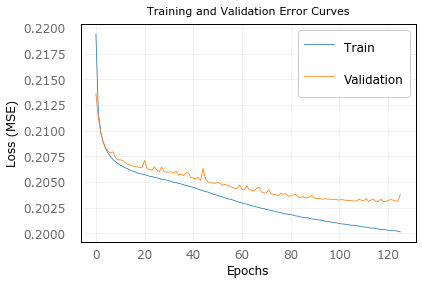

In [19]:
plot_training_error_curves(history)

## Predições no conjunto de teste (MLP)

Matriz de confusão no conjunto de teste:
[[58690  5085]
 [26046  7479]]

Train Loss:       0.2005
Validation Loss:  0.2031

Performance no conjunto de teste:


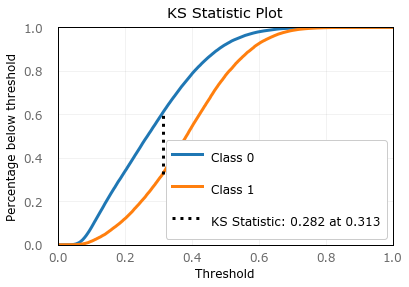


Accuracy:         0.6801
Recall:           0.2231
Precision:        0.5953
F1:               0.3245
AUROC:            0.6916
AUPR:             0.5217


In [21]:
# Fazer predições no conjunto de teste
y_pred_scores = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)
y_pred_scores_0 = 1 - y_pred_scores
y_pred_scores = concatenate([y_pred_scores_0, y_pred_scores], axis=1)

## Matriz de confusão
print('Matriz de confusão no conjunto de teste:')
print(confusion_matrix(y_test, y_pred_class))

## Resumo dos resultados
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print('\nPerformance no conjunto de teste:')
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_class, y_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Comparando MLPs com outros classificadores

C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Carlos\Anaconda3\envs\IF702-redes-neurais\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


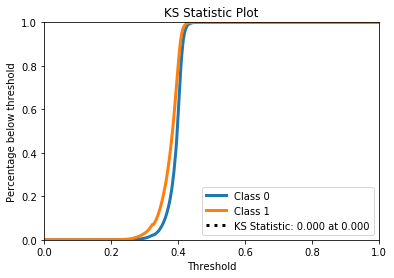

Performance no conjunto de validação:

Accuracy:         0.6554
Recall:           0.0000
Precision:        0.0000
F1:               0.0000
AUROC:            0.3251
AUPR:             0.2548


In [14]:
svc_clf = SVC(probability=True)  # Modifique aqui os hyperparâmetros
svc_clf.fit(X_train, y_train)
svc_pred_class = svc_clf.predict(X_val)
svc_pred_scores = svc_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, svc_pred_class, svc_pred_scores)
print('Performance no conjunto de validação:')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

      Iter       Train Loss   Remaining Time 
         1           1.2776           12.70m
         2           1.2690           11.84m
         3           1.2617           11.75m
         4           1.2554           11.61m
         5           1.2492           11.36m
         6           1.2445           11.19m
         7           1.2399           10.93m
         8           1.2352           10.75m
         9           1.2318           10.60m
        10           1.2266           10.40m
        11           1.2236           10.24m
        12           1.2207           10.09m
        13           1.2182            9.97m
        14           1.2160            9.80m
        15           1.2141            9.62m
        16           1.2106            9.52m
        17           1.2079            9.39m
        18           1.2056            9.24m
        19           1.2042            9.12m
        20           1.2028            8.98m
        21           1.2007            8.86m
        2

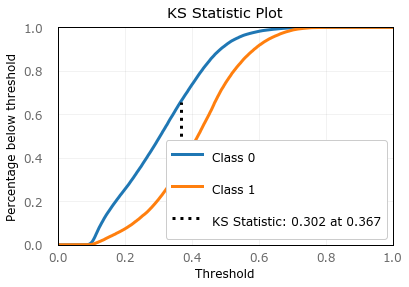


Accuracy:         0.6898
Recall:           0.2581
Precision:        0.6197
F1:               0.3644
AUROC:            0.7065
AUPR:             0.5463


In [22]:
gb_clf = GradientBoostingClassifier(verbose=2)  # Modifique aqui os hyperparâmetros
gb_clf.fit(X_train, y_train)
gb_pred_class = gb_clf.predict(X_val)
gb_pred_scores = gb_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, gb_pred_class, gb_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


building tree 2 of 10
building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   30.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


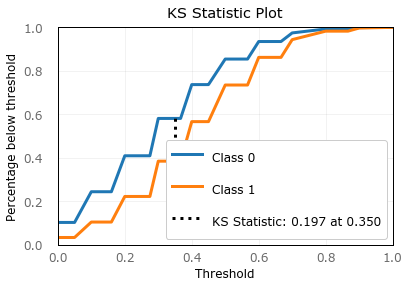


Accuracy:         0.6513
Recall:           0.2652
Precision:        0.4888
F1:               0.3438
AUROC:            0.6340
AUPR:             0.4420


In [23]:
rf_clf = RandomForestClassifier(verbose=2)  # Modifique aqui os hyperparâmetros
rf_clf.fit(X_train, y_train)
rf_pred_class = rf_clf.predict(X_val)
rf_pred_scores = rf_clf.predict_proba(X_val)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_val, rf_pred_class, rf_pred_scores)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Performance dos classificadores no conjunto de teste

In [ ]:
gb_pred_class = gb_clf.predict(X_test)
gb_pred_scores = gb_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, gb_pred_class, gb_pred_scores)
print('\n\nGradient Boosting')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

rf_pred_class = rf_clf.predict(X_test)
rf_pred_scores = rf_clf.predict_proba(X_test)
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, rf_pred_class, rf_pred_scores)
print('\n\nRandom Forest')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

## Run SVM with GridSearch

In [ ]:
tuned_parameters = {'kernel': ['rbf', 'linear'], 'gamma': [0.001, 0.0001, 0.00001],
                     'C': [1, 10, 100, 1000]}

In [ ]:
print("# Tuning hyper-parameters for accuracy")
clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                   scoring = 'accuracy')
clf.fit(X_train, y_train)

In [ ]:
print("Best parameters set found on development set:")
print(clf.best_params_)

print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    
print("Detailed classification report:")
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")

y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))